In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
hist = pd.read_csv('./Data/historical_data.csv', low_memory=False)
sent = pd.read_csv('./Data/fear_greed_index.csv', low_memory=False)
print('Loaded shapes -> hist:', hist.shape, 'sent:', sent.shape)

display(hist.head(3))
display(sent.head(3))

Loaded shapes -> hist: (211224, 16) sent: (2644, 4)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03


In [ ]:
hist.columns = [c.strip() for c in hist.columns]
sent.columns = [c.strip() for c in sent.columns]

time_cols = [c for c in hist.columns if 'time' in c.lower() or 'timestamp' in c.lower()]
print("Found possible time columns in hist:", time_cols)

hist['time_parsed'] = pd.NaT
for col in time_cols:
    try:
        if pd.api.types.is_numeric_dtype(hist[col]):
            sample_max = hist[col].dropna().astype(float).max() if not hist[col].dropna().empty else 0
            if sample_max > 1e10:
                hist['time_parsed'] = pd.to_datetime(hist[col], unit='ms', errors='coerce')
            else:
                hist['time_parsed'] = pd.to_datetime(hist[col], unit='s', errors='coerce')
        else:
            hist['time_parsed'] = pd.to_datetime(hist[col], errors='coerce')
        if hist['time_parsed'].notna().any():
            print("Parsed timestamps using column:", col)
            break
    except Exception as e:
        continue

sent['date_parsed'] = pd.NaT
if 'timestamp' in sent.columns:
    sample_max = sent['timestamp'].dropna().astype(float).max() if not sent['timestamp'].dropna().empty else 0
    if sample_max > 1e10:
        sent['date_parsed'] = pd.to_datetime(sent['timestamp'], unit='ms', errors='coerce')
    else:
        sent['date_parsed'] = pd.to_datetime(sent['timestamp'], unit='s', errors='coerce')
else:
    sent_time_cols = [c for c in sent.columns if 'time' in c.lower() or 'date' in c.lower()]
    if sent_time_cols:
        sent['date_parsed'] = pd.to_datetime(sent[sent_time_cols[0]], errors='coerce')

hist['date'] = pd.to_datetime(hist['time_parsed'], errors='coerce')
sent['date'] = pd.to_datetime(sent['date_parsed'], errors='coerce')

hist = hist.dropna(subset=['date'])
sent = sent.dropna(subset=['date'])

hist['date'] = hist['date'].dt.date
sent['date'] = sent['date'].dt.date

print("Trade date range:", hist['date'].min(), "->", hist['date'].max())
print("Sentiment date range:", sent['date'].min(), "->", sent['date'].max())


Found possible time columns in hist: ['Timestamp IST', 'Timestamp']
Parsed timestamps using column: Timestamp IST
Trade date range: 2023-01-05 -> 2025-12-04
Sentiment date range: 2018-02-01 -> 2025-05-02


In [ ]:
print("🔍 Basic Info:")
print(f"Hist shape: {hist.shape}")
print(f"Sent shape: {sent.shape}\n")

print("Hist columns:", hist.columns.tolist())
print("Sent columns:", sent.columns.tolist())

print("\n📊 Missing values summary (hist, top 8):")
display(hist.isnull().sum().sort_values(ascending=False).head(8).to_frame("Missing Count"))

print("\n📊 Missing values summary (sent):")
display(sent.isnull().sum().to_frame("Missing Count"))

print("\n🧩 Sample from hist:")
display(hist.head(3))

print("\n🧩 Sample from sent:")
display(sent.head(3))


🔍 Basic Info:
Hist shape: (79225, 18)
Sent shape: (2644, 5)

Hist columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp', 'time_parsed', 'date']
Sent columns: ['timestamp', 'value', 'classification', 'date', 'date_parsed']

📊 Missing values summary (hist, top 8):


,Missing Count
Account,0
Coin,0
Execution Price,0
Size Tokens,0
Size USD,0
Side,0
Timestamp IST,0
Start Position,0



📊 Missing values summary (sent):


,Missing Count
timestamp,0
value,0
classification,0
date,0
date_parsed,0



🧩 Sample from hist:


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,time_parsed,date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12



🧩 Sample from sent:


,timestamp,value,classification,date,date_parsed
0,1517463000,30,Fear,2018-02-01,2018-02-01 05:30:00
1,1517549400,15,Extreme Fear,2018-02-02,2018-02-02 05:30:00
2,1517635800,40,Fear,2018-02-03,2018-02-03 05:30:00


In [ ]:
cols_lower = [c.lower() for c in hist.columns]
account_col = next((hist.columns[i] for i,c in enumerate(cols_lower) if 'account' in c or 'wallet' in c or 'user' in c), None)
pnl_col = next((hist.columns[i] for i,c in enumerate(cols_lower) if 'pnl' in c or 'profit' in c), None)
print('Detected account_col =', account_col, 'pnl_col =', pnl_col)

if account_col is None or pnl_col is None:
    raise KeyError('Could not detect account or pnl column. Columns: ' + ','.join(hist.columns))

hist[pnl_col] = pd.to_numeric(hist[pnl_col], errors='coerce')

agg = hist.groupby(account_col).agg(
    trades=(account_col, 'count'),
    total_pnl=(pnl_col, 'sum'),
    mean_pnl=(pnl_col, 'mean'),
    median_pnl=(pnl_col, 'median')
).reset_index().sort_values('total_pnl', ascending=False)

print('Top accounts by total PnL:')
display(agg.head(10))


Detected account_col = Account pnl_col = Closed PnL
Top accounts by total PnL:


,Account,trades,total_pnl,mean_pnl,median_pnl
27,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,7754,1.674353e+06,215.934141,0.000000
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2712,1.359428e+06,501.263878,0.000000
29,0xbaaaf6571ab7d571043ff1e313a9609a10637864,10072,8.177643e+05,81.191850,0.012658
11,0x4acb90e786d897ecffb614dc822eb231b4ffb9f4,2274,4.048552e+05,178.036601,0.000000
31,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,11124,2.731970e+05,24.559241,0.000000
16,0x72c6a4624e1dffa724e6d00d64ceae698af892a0,472,2.017160e+05,427.364433,0.000000
17,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,3333,1.693366e+05,50.806071,10.695055
15,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,737,1.560309e+05,211.710810,0.000000
13,0x513b8629fe877bb581bf244e326a047b249c4ff1,2555,1.004826e+05,39.327831,0.000000
12,0x4f93fead39b70a1824f981a54d4e55b278e9f760,2938,9.801994e+04,33.362812,0.000000


In [ ]:
if 'date' not in sent.columns:
    sent['date'] = pd.to_datetime(sent.get('date_parsed'), errors='coerce').dt.date

sent_cols = [c for c in ['date','value','classification'] if c in sent.columns]
merged = pd.merge(hist, sent[sent_cols], on='date', how='left')
print('Merged shape:', merged.shape)
display(merged[[account_col,'date','value','classification',pnl_col]].head())

Merged shape: (79225, 20)


,Account,date,value,classification,Closed PnL
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,2024-02-12,70.0,Greed,0.0
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,2024-02-12,70.0,Greed,0.0
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,2024-02-12,70.0,Greed,0.0
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,2024-02-12,70.0,Greed,0.0
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,2024-02-12,70.0,Greed,0.0


In [ ]:
# A) Account-level sentiment exposure & performance by sentiment (safe version)

# --- Detect account and pnl columns dynamically ---
account_col = next((c for c in merged.columns if any(k in c.lower() for k in ['account', 'wallet', 'trader', 'user'])), None)
pnl_col = next((c for c in merged.columns if any(k in c.lower() for k in ['pnl', 'profit', 'closed'])), None)

print(f"Detected account_col = {account_col}, pnl_col = {pnl_col}")

# --- Validate existence ---
if account_col is None or pnl_col is None:
    print("❌ Could not find account or PnL column. Available columns:")
    print(list(merged.columns))
else:
    # 1️⃣ Mean sentiment exposure per account
    acct_sent = merged.groupby(account_col).agg(
        trades=('date','count'),
        mean_sentiment=('value','mean'),
        median_sentiment=('value','median'),
        total_pnl=(pnl_col,'sum'),
        mean_pnl=(pnl_col,'mean')
    ).reset_index()

    print("Top accounts by total_pnl (example):")
    display(acct_sent.sort_values('total_pnl', ascending=False).head(10))

    # 2️⃣ Per-account performance split by sentiment classification
    if 'classification' in merged.columns:
        acct_by_class = merged.pivot_table(
            index=account_col,
            columns='classification',
            values=pnl_col,
            aggfunc=['count','sum','mean']
        )
        # flatten columns
        acct_by_class.columns = ['__'.join(map(str,c)).strip() for c in acct_by_class.columns.values]
        acct_by_class = acct_by_class.reset_index()
        print("Sample of per-account, per-class metrics:")
        display(acct_by_class.head(5))
    else:
        print("⚠️ No 'classification' column found; skipping per-class analysis.")


Detected account_col = Account, pnl_col = Closed PnL
Top accounts by total_pnl (example):


,Account,trades,mean_sentiment,median_sentiment,total_pnl,mean_pnl
27,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,7754,58.982184,67.0,1.674353e+06,215.934141
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2712,40.289220,33.0,1.359428e+06,501.263878
29,0xbaaaf6571ab7d571043ff1e313a9609a10637864,10072,35.363778,25.0,8.177643e+05,81.191850
11,0x4acb90e786d897ecffb614dc822eb231b4ffb9f4,2274,26.518272,25.0,4.048552e+05,178.036601
31,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,11124,50.906387,49.0,2.731970e+05,24.559241
16,0x72c6a4624e1dffa724e6d00d64ceae698af892a0,472,38.855124,25.0,2.017160e+05,427.364433
17,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,3333,54.842993,67.0,1.693366e+05,50.806071
15,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,737,34.000000,34.0,1.560309e+05,211.710810
13,0x513b8629fe877bb581bf244e326a047b249c4ff1,2555,65.250958,72.0,1.004826e+05,39.327831
12,0x4f93fead39b70a1824f981a54d4e55b278e9f760,2938,57.817367,67.0,9.801994e+04,33.362812


Sample of per-account, per-class metrics:


,Account,count__Extreme Fear,count__Extreme Greed,count__Fear,count__Greed,count__Neutral,sum__Extreme Fear,sum__Extreme Greed,sum__Fear,sum__Greed,sum__Neutral,mean__Extreme Fear,mean__Extreme Greed,mean__Fear,mean__Greed,mean__Neutral
0,0x083384f897ee0f19899168e3b1bec365f52a9012,NaN,177.0,2011.0,298.0,NaN,NaN,0.000000,1.010607e+06,-45017.872815,NaN,NaN,0.000000,502.539343,-151.066687,NaN
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,1.0,NaN,247.0,880.0,64.0,0.000000,NaN,2.826578e+03,8758.308723,2517.787385,0.000000,NaN,11.443636,9.952624,39.340428
2,0x271b280974205ca63b716753467d5a371de622ab,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,208.817460,NaN,NaN,NaN,NaN,52.204365,NaN
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,154.0,430.0,879.0,1035.0,239.0,400.093828,17645.398797,1.678161e+04,22639.472053,1068.309642,2.598012,41.035811,19.091706,21.873886,4.469915
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,26.0,191.0,15.0,134.0,12.0,160.127816,23897.024855,-7.107869e+02,19563.534860,130.883691,6.158762,125.115313,-47.385796,145.996529,10.906974


In [ ]:
# B) Statistical differences + effect sizes between Fear and Greed
import numpy as np
import scipy.stats as st

if 'classification' in merged.columns:
    fear = merged.loc[merged['classification'].str.contains('Fear', na=False, case=False), pnl_col].dropna()
    greed = merged.loc[merged['classification'].str.contains('Greed', na=False, case=False), pnl_col].dropna()
    print("Counts: fear=", len(fear), "greed=", len(greed))

    # Mann-Whitney U
    if len(fear)>20 and len(greed)>20:
        u, p_mw = st.mannwhitneyu(fear, greed, alternative='two-sided')
        print(f"Mann-Whitney U p-value = {p_mw:.4f}")
    else:
        p_mw = np.nan
        print("Not enough samples for Mann-Whitney.")

    # Cohen's d
    def cohens_d(x,y):
        nx, ny = len(x), len(y)
        dof = nx + ny - 2
        pooled_sd = np.sqrt(((nx-1)*x.var(ddof=1) + (ny-1)*y.var(ddof=1)) / dof)
        return (x.mean() - y.mean()) / pooled_sd if pooled_sd!=0 else np.nan
    d = cohens_d(greed, fear)
    print(f"Cohen's d (greed - fear) = {d:.4f}")

    # Permutation test (mean difference) - robust nonparametric
    if len(fear)>50 and len(greed)>50:
        from scipy.stats import permutation_test
        res = permutation_test((greed, fear),
                               statistic=lambda a,b: np.mean(a)-np.mean(b),
                               permutation_type='independent',
                               n_resamples=5000,
                               alternative='two-sided')
        print(f"Permutation test p-value = {res.pvalue:.4f}")
else:
    print("No classification column found; skipping Fear vs Greed stats.")


Counts: fear= 16195 greed= 16913
Mann-Whitney U p-value = 0.0000
Cohen's d (greed - fear) = -0.0040
Permutation test p-value = 0.7371


In [ ]:
merged.columns = [c.strip().lower().replace(' ', '_') for c in merged.columns]
account_col = next((c for c in merged.columns if 'account' in c), None)
pnl_col = next((c for c in merged.columns if 'pnl' in c), None)

if 'classification' in merged.columns and merged['classification'].notna().any():
    grp = merged.groupby('classification').agg(
        trades=(account_col,'count'),
        total_pnl=(pnl_col,'sum'),
        mean_pnl=(pnl_col,'mean'),
        median_pnl=(pnl_col,'median'),
        win_rate=(pnl_col, lambda x: (x>0).sum()/x.count() if x.count()>0 else np.nan)
    ).reset_index().sort_values('total_pnl', ascending=False)
else:
    merged['sent_bin'] = pd.cut(merged['value'], bins=5)
    grp = merged.groupby('sent_bin').agg(trades=(account_col,'count'), total_pnl=(pnl_col,'sum'), mean_pnl=(pnl_col,'mean')).reset_index().sort_values('total_pnl', ascending=False)

print('Performance by sentiment group:')
display(grp)


Performance by sentiment group:


,classification,trades,total_pnl,mean_pnl,median_pnl,win_rate
2,Fear,13869,1.779226e+06,128.287950,0.00000,0.381787
1,Extreme Greed,5621,1.156894e+06,205.816345,0.96048,0.553282
3,Greed,11292,6.096325e+05,53.988003,0.00000,0.435707
4,Neutral,2756,7.465674e+04,27.088803,0.00000,0.494920
0,Extreme Fear,2326,4.399937e+03,1.891632,0.00000,0.292777


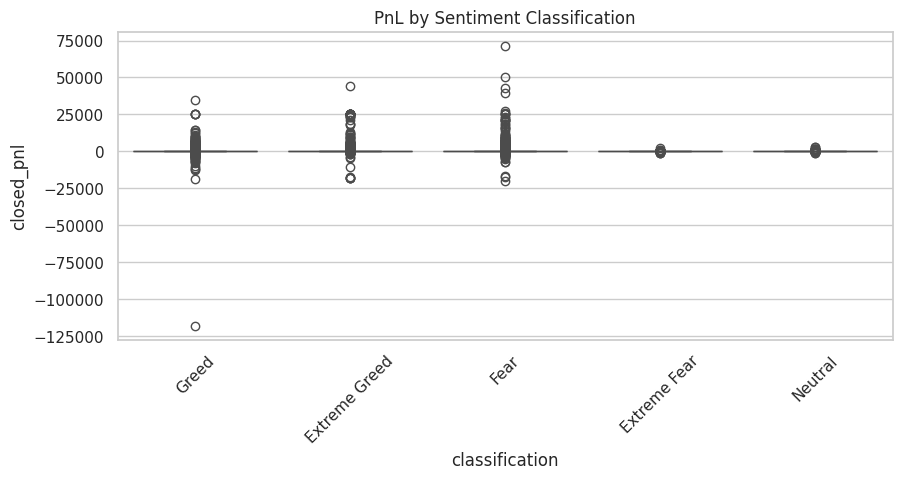

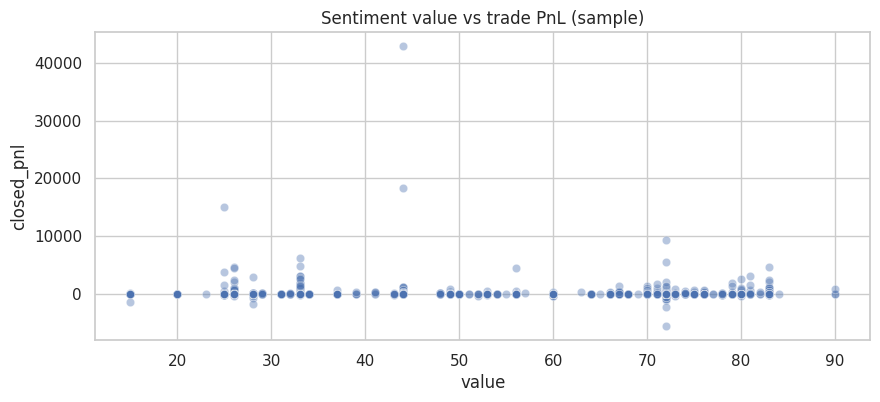

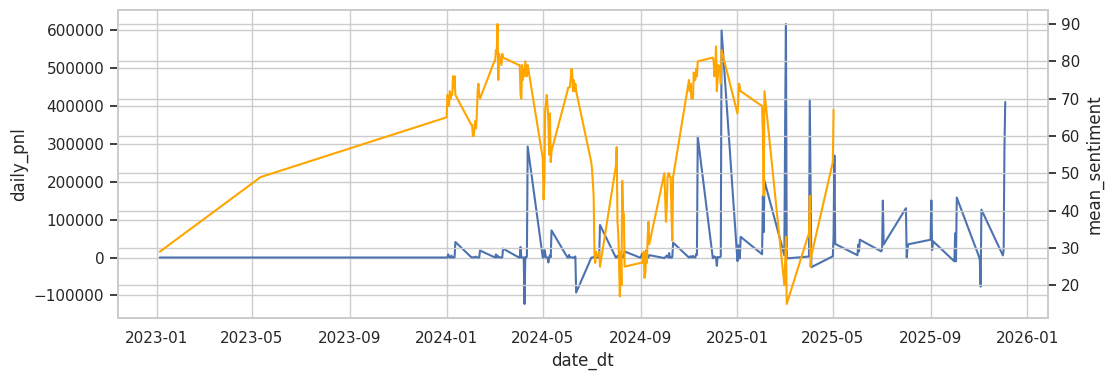

In [ ]:
import matplotlib.dates as mdates
plt.figure(figsize=(10,4))
if 'classification' in merged.columns and merged['classification'].notna().any():
    sns.boxplot(data=merged, x='classification', y=pnl_col)
    plt.title('PnL by Sentiment Classification')
    plt.xticks(rotation=45)
else:
    sns.boxplot(data=merged, x='sent_bin', y=pnl_col)
    plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,4))
sns.scatterplot(data=merged.sample(min(5000,len(merged))), x='value', y=pnl_col, alpha=0.4)
plt.title('Sentiment value vs trade PnL (sample)')
plt.show()

daily = merged.groupby('date').agg(daily_pnl=(pnl_col,'sum'), mean_sentiment=('value','mean')).reset_index()
daily['date_dt'] = pd.to_datetime(daily['date'])
plt.figure(figsize=(12,4))
ax = plt.gca()
sns.lineplot(data=daily, x='date_dt', y='daily_pnl', ax=ax)
ax2 = ax.twinx()
sns.lineplot(data=daily, x='date_dt', y='mean_sentiment', ax=ax2, color='orange')
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()


In [ ]:
import scipy.stats as stats
from scipy.stats import permutation_test
from statsmodels.tsa.stattools import grangercausalitytests

if 'classification' in merged.columns and merged['classification'].notna().any():
    fear = merged.loc[merged['classification'].str.contains('Fear', case=False, na=False), pnl_col].dropna()
    greed = merged.loc[merged['classification'].str.contains('Greed', case=False, na=False), pnl_col].dropna()
else:
    fear = pd.Series([], dtype=float)
    greed = pd.Series([], dtype=float)

print('Fear trades:', len(fear), 'Greed trades:', len(greed))

if len(fear)>20 and len(greed)>20:
    u_stat, p_val = stats.mannwhitneyu(fear, greed, alternative='two-sided')
    print('Mann-Whitney U p-value:', p_val)
else:
    print('Not enough samples for Mann-Whitney test')

if len(fear)>50 and len(greed)>50:
    perm = permutation_test((fear, greed), statistic=lambda x,y: np.mean(x)-np.mean(y), permutation_type='independent', n_resamples=2000)
    print('Permutation test p-value:', perm.pvalue)
else:
    print('Not enough samples for permutation test')

daily_ts = merged.groupby('date').agg(daily_pnl=(pnl_col,'sum'), mean_sentiment=('value','mean')).dropna()
if len(daily_ts)>50:
    try:
        print('Running Granger causality tests (lags 1-3)')
        grangercausalitytests(daily_ts[['daily_pnl','mean_sentiment']], maxlag=3, verbose=False)
        print('Granger tests completed')
    except Exception as e:
        print('Granger test error:', e)
else:
    print('Not enough daily data for Granger test')

Fear trades: 16195 Greed trades: 16913
Mann-Whitney U p-value: 1.384301904177245e-68
Permutation test p-value: 0.7156421789105447
Running Granger causality tests (lags 1-3)
Granger tests completed


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [ ]:
df_feat = merged.copy()
if 'entry_time' in df_feat.columns and 'exit_time' in df_feat.columns:
    df_feat['entry_time'] = pd.to_datetime(df_feat['entry_time'], errors='coerce')
    df_feat['exit_time'] = pd.to_datetime(df_feat['exit_time'], errors='coerce')
    df_feat['trade_duration_hrs'] = (df_feat['exit_time'] - df_feat['entry_time']).dt.total_seconds()/3600
else:
    df_feat['trade_duration_hrs'] = np.nan

if 'leverage' in df_feat.columns:
    df_feat['leverage_adj_return'] = df_feat[pnl_col] / df_feat['leverage'].replace(0, np.nan)
else:
    df_feat['leverage_adj_return'] = np.nan

display(df_feat[['trade_duration_hrs','leverage_adj_return']].head())

,trade_duration_hrs,leverage_adj_return
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


In [ ]:
summary = merged.groupby('classification' if 'classification' in merged.columns else pd.cut(merged['value'],5)).agg(
    avg_pnl=(pnl_col,'mean'),
    median_pnl=(pnl_col,'median'),
    pnl_std=(pnl_col,'std'),
    trade_count=(pnl_col,'count')
).sort_values('avg_pnl', ascending=False)

display(summary.round(3))


,avg_pnl,median_pnl,pnl_std,trade_count
classification,,,,
Extreme Greed,205.816,0.96,1861.557,5621
Fear,128.288,0.00,1342.348,13869
Greed,53.988,0.00,1399.468,11292
Neutral,27.089,0.00,142.946,2756
Extreme Fear,1.892,0.00,76.728,2326
